In [2]:
!pip install tensorboard

100%|██████████| 9912422/9912422 [00:00<00:00, 21462330.83it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 3239008.90it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4973865.51it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 698000.54it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

epoch 1 / 2, step 100 / 600, loss = 0.3781
epoch 1 / 2, step 200 / 600, loss = 0.3191
epoch 1 / 2, step 300 / 600, loss = 0.2992
epoch 1 / 2, step 400 / 600, loss = 0.3101
epoch 1 / 2, step 500 / 600, loss = 0.2744
epoch 1 / 2, step 600 / 600, loss = 0.2847
epoch 2 / 2, step 100 / 600, loss = 0.1152
epoch 2 / 2, step 200 / 600, loss = 0.1660
epoch 2 / 2, step 300 / 600, loss = 0.2727
epoch 2 / 2, step 400 / 600, loss = 0.2369
epoch 2 / 2, step 500 / 600, loss = 0.1199
epoch 2 / 2, step 600 / 600, loss = 0.1159
acc = 95.29


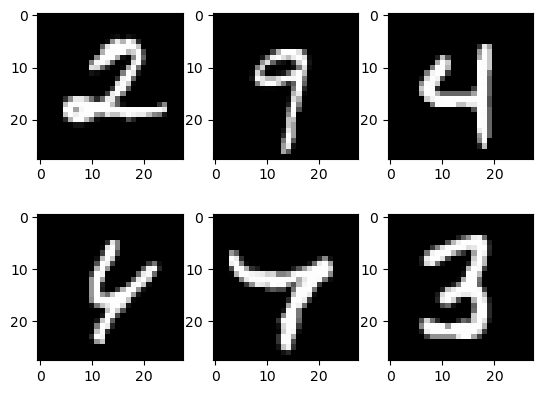

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
writer = SummaryWriter("runs/mnist")

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyper parameters
input_size = 784 # 28*28
hidden_size = 100
num_classes = 10
num_epoches = 2
batch_size = 100
learning_rate = 0.001

# MNIST
train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transforms.ToTensor(), download=True
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True 
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True 
)

examples = iter(test_loader)
example_data, example_targets = next(examples)

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
#plt.show()

############## TENSORBOARD ########################
img_grid = torchvision.utils.make_grid(example_data)
writer.add_image('mnist_images', img_grid)
###################################################

# Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out
    
model = NeuralNet(input_size, hidden_size, num_classes)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

############## TENSORBOARD ########################
writer.add_graph(model, example_data.reshape(-1, 28*28).to(device))
###################################################

# training loop
running_loss = 0.0
running_correct = 0
n_total_steps = len(train_loader)
for epoch in range(num_epoches):
    for i, (images, labels) in enumerate(train_loader):
        # 100, 1, 28, 28
        # 100, 784
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f"epoch {epoch+1} / {num_epoches}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}")
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / 100, epoch * n_total_steps + i)
            running_accuracy = running_correct / 100 / predicted.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0
            ###################################################


# test
class_labels = []
class_preds = []

model.eval()
n_correct = 0
n_samples = 0
for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)

    # value, index
    values, predicted = torch.max(outputs.data, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

    class_probs_batch = [F.softmax(output, dim=0) for output in outputs]

    class_preds.append(class_probs_batch)
    class_labels.append(labels)

class_preds = torch.cat([torch.stack(batch) for batch in class_preds])
class_labels = torch.cat(class_labels)

acc = 100.0 * n_correct / n_samples
print(f'acc = {acc}')

############## TENSORBOARD ########################
classes = range(10)
for i in classes:
    labels_i = class_labels == i
    preds_i = class_preds[:, i]
    writer.add_pr_curve(str(i), labels_i, preds_i, global_step=0)
    writer.close()
###################################################